# Sign Language Model (Google Kaggle Comp)


Hi, this will officially be my first submission. I hope this notebook helps anyone, and I would love any feedback; always eager to learn!

Apologies in advance if the content is too verbose; still consider myself a novice. 

## Data Exploration

Objective: 

1) Understand the data structure/format
2) Visualize data
3) Brainstorm possible solutions (Minimum viable product)


In [10]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import os
import plotly.express as px

# Sample Data Exploration

In [2]:
df_train = pd.read_csv('train.csv')

df_train

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie
...,...,...,...,...
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room


In [3]:
df_train['sign'].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64

<AxesSubplot:title={'center':'50/250 Sing Counts'}, ylabel='count'>

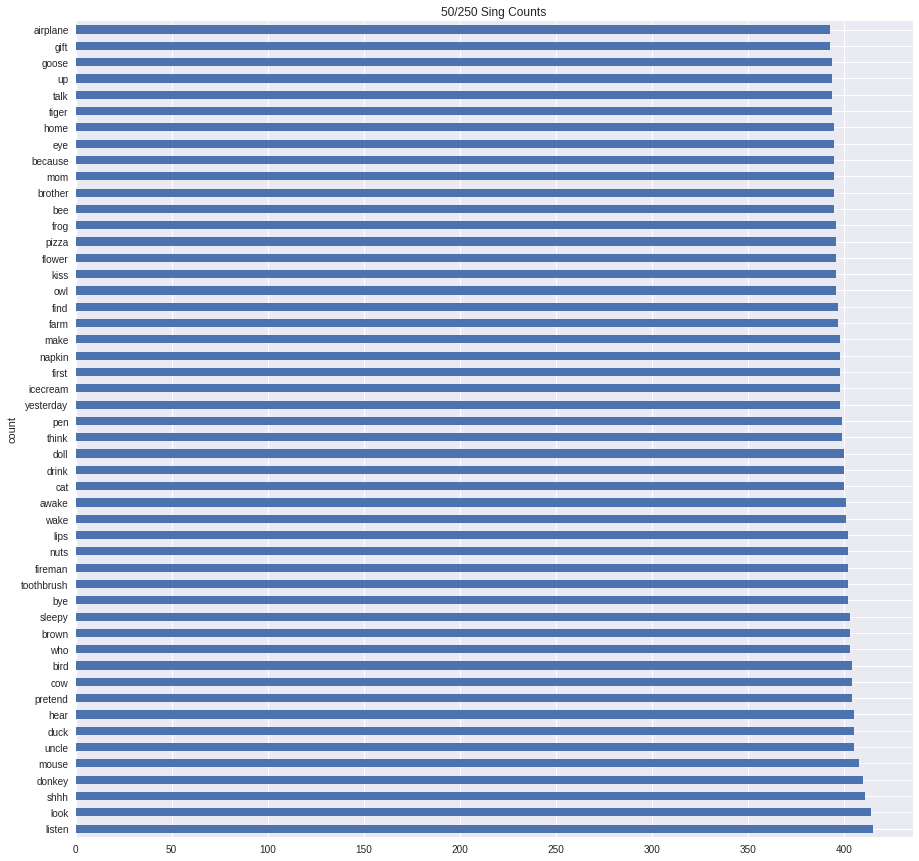

In [4]:
plt.style.use('seaborn')
df_train['sign'].value_counts().head(50).plot(
    kind='barh',figsize=(15,15), title="50/250 Sing Counts", xlabel="count")



In [5]:
example_path = df_train.query('sign == "gift"')["path"].values[0]

example_landmark = pd.read_parquet(f"{os.getcwd()}/{example_path}")
example_landmark

# can the x, y and z be null?

,frame,row_id,type,landmark_index,x,y,z
0,18,18-face-0,face,0,0.481154,0.417818,-0.054069
1,18,18-face-1,face,1,0.484775,0.394146,-0.057618
2,18,18-face-2,face,2,0.483704,0.410014,-0.040766
3,18,18-face-3,face,3,0.476430,0.374310,-0.026645
4,18,18-face-4,face,4,0.485234,0.385773,-0.056272
...,...,...,...,...,...,...,...
3796,24,24-right_hand-16,right_hand,16,0.181681,0.590627,-0.087710
3797,24,24-right_hand-17,right_hand,17,0.333034,0.620677,-0.075964
3798,24,24-right_hand-18,right_hand,18,0.310118,0.624032,-0.112319
3799,24,24-right_hand-19,right_hand,19,0.248546,0.631576,-0.104538


In [6]:
example_landmark.isnull().any()

# So it can be null hmmmm

frame             False
row_id            False
type              False
landmark_index    False
x                  True
y                  True
z                  True
dtype: bool

In [7]:
null_example = example_landmark[example_landmark["x"].isnull() | example_landmark["y"].isnull() | example_landmark["z"].isnull()]

null_example

,frame,row_id,type,landmark_index,x,y,z
468,18,18-left_hand-0,left_hand,0,NaN,NaN,NaN
469,18,18-left_hand-1,left_hand,1,NaN,NaN,NaN
470,18,18-left_hand-2,left_hand,2,NaN,NaN,NaN
471,18,18-left_hand-3,left_hand,3,NaN,NaN,NaN
472,18,18-left_hand-4,left_hand,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3742,24,24-left_hand-16,left_hand,16,NaN,NaN,NaN
3743,24,24-left_hand-17,left_hand,17,NaN,NaN,NaN
3744,24,24-left_hand-18,left_hand,18,NaN,NaN,NaN
3745,24,24-left_hand-19,left_hand,19,NaN,NaN,NaN


In [8]:
# TEST_DF = 100
def create_meta() -> pd.DataFrame():
    count = 0
    output_df = []
    for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
        temp_df_pq = pd.read_parquet(f"{os.getcwd()}/{row['path']}")
        curr_df = temp_df_pq.dropna(subset=["x","y","z"])["type"].value_counts().to_dict()
        dict_test = temp_df_pq.agg({"x": ["min", "max", "mean"],
                                    "y": ["min", "max", "mean"],
                                    "z": ["min", "max", "mean"],
                                    }).unstack().to_dict()
        for key, value in dict_test.items():
            curr_df[key[0] + "_" + key[1]] = value
        curr_df["frames_unique_count"] = temp_df_pq["frame"].nunique()
        curr_df["file"] = row['path']
        count += 1
        output_df.append(curr_df)

        # if count == TEST_DF:
        #     break
    
    return pd.DataFrame(output_df)

meta_df = create_meta()
meta_df

  0%|          | 0/94477 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
merged_meta_df =  pd.merge(df_train, meta_df, left_on='path', right_on='file').drop('file', axis=1)
merged_meta_df

NameError: name 'meta_df' is not defined

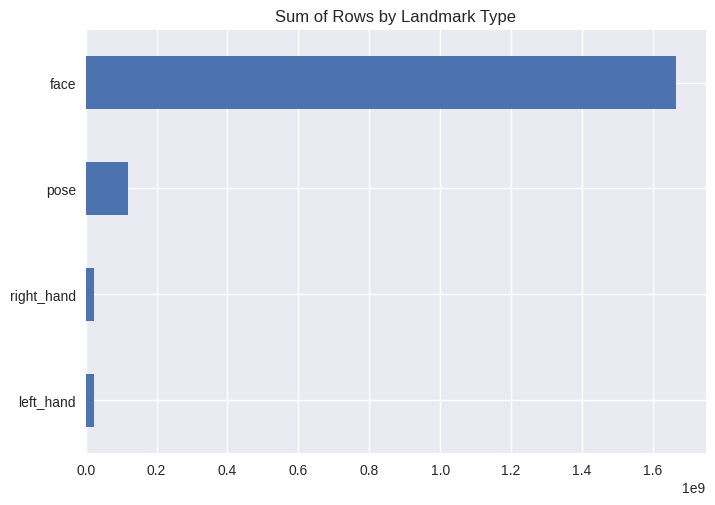

In [ ]:
merged_meta_df[["face", "pose", "left_hand", "right_hand"]].sum().sort_values().plot(
    kind="barh", title="Sum of Rows by Landmark Type"
)
plt.show()

In [ ]:
# to check if all frames have a face value

merged_meta_df["face"].notnull().sum() == len(merged_meta_df)

False

In [ ]:
# to check if all frames have a pose value

merged_meta_df["pose"].notnull().sum() == len(merged_meta_df)

True

In [ ]:
example_landmark_frame = example_landmark.query("frame == 18")
px.scatter_3d(example_landmark_frame, x="x", y="y", z="z", color="Type")




NameError: name 'example_landmark' is not defined

## Exploratory Data  analysis

1) Not all signs require hands and face ; they could be null (makes intuitive sense). however, there is always a pose value